# KLASIFIKASI GEMPA

---

# 1. MODEL KLASIFIKASI GEMPA

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

In [2]:
# setting
# display max columns
pd.set_option('display.max_columns', None)

# ignore warnings
warnings.filterwarnings('ignore')

## - DATA UNDERSTANDING

In [3]:
 # read dataset
df_raw = pd.read_csv('dataset/data_gempa_raw.csv')

In [4]:
df_raw

,aX,aY,aZ,gX,gY,gMZ,Result
0,-2176,996,-16868,-5168,3575,-2882,1
1,-2176,996,-16868,-5168,3575,-2882,1
2,-6564,-1340,-13532,-5136,-8924,3258,1
3,-8,2316,-23504,-5168,5999,11,1
4,17064,-5608,10432,-5152,-4301,1899,1
...,...,...,...,...,...,...,...
59271,-616,-1468,-17128,-3536,91,279,0
59272,-640,-1448,-17228,-3552,67,269,0
59273,-620,-1508,-17080,-3568,49,327,0
59274,-596,-1460,-17220,-3584,52,227,0


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59276 entries, 0 to 59275
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   aX      59276 non-null  int64
 1   aY      59276 non-null  int64
 2   aZ      59276 non-null  int64
 3   gX      59276 non-null  int64
 4   gY      59276 non-null  int64
 5   gMZ     59276 non-null  int64
 6   Result  59276 non-null  int64
dtypes: int64(7)
memory usage: 3.2 MB


In [6]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
aX,59276.0,95.636126,9595.021351,-32768.0,-1180.0,-656.0,1500.0,32767.0
aY,59276.0,-1165.866168,5704.585744,-32768.0,-1520.0,-1372.0,-756.0,32767.0
aZ,59276.0,-14675.366033,14835.340037,-32768.0,-17852.0,-17200.0,-16312.0,32767.0
gX,59276.0,-3510.458786,399.606856,-5200.0,-3760.0,-3488.0,-3328.0,-1.0
gY,59276.0,34.997588,4192.662583,-32768.0,-82.0,61.0,102.0,32767.0
gMZ,59276.0,311.795617,4514.127802,-32768.0,220.0,269.0,376.0,32767.0
Result,59276.0,0.516195,0.499742,0.0,0.0,1.0,1.0,1.0


In [7]:
df_raw['Result'].value_counts()

1    30598
0    28678
Name: Result, dtype: int64

In [8]:
df_raw['Result'].value_counts(normalize=True)*100

1    51.619542
0    48.380458
Name: Result, dtype: float64

## - DATA PREPROCESSING 1

Data akan dikonversi dalam satuan g untuk accelerometer, dan dalam satuan deg/s untuk gyroscope

In [9]:
# rename column
df_raw=df_raw.rename(columns = {'gMZ':'gZ', 'Result':'result'})
# atur max min gY & gZ (agar sesuai skala +-250)
df_raw['gY'] = np.where(df_raw['gY'] <= -32750, -32750, 
                        np.where(df_raw['gY'] >= 32750, 32750, 
                                 df_raw['gY']))
df_raw['gZ'] = np.where(df_raw['gZ'] <= -32750, -32750, 
                        np.where(df_raw['gZ'] >= 32750, 32750, 
                                 df_raw['gZ']))
# konversi
df_raw['aX']=(df_raw['aX']/16384).round(2)
df_raw['aY']=(df_raw['aY']/16384).round(2)
df_raw['aZ']=(df_raw['aZ']/16384).round(2)
df_raw['gX']=(df_raw['gX']/131).round(2)
df_raw['gY']=(df_raw['gY']/131).round(2)
df_raw['gZ']=(df_raw['gZ']/131).round(2)

In [10]:
df_raw

,aX,aY,aZ,gX,gY,gZ,result
0,-0.13,0.06,-1.03,-39.45,27.29,-22.00,1
1,-0.13,0.06,-1.03,-39.45,27.29,-22.00,1
2,-0.40,-0.08,-0.83,-39.21,-68.12,24.87,1
3,-0.00,0.14,-1.43,-39.45,45.79,0.08,1
4,1.04,-0.34,0.64,-39.33,-32.83,14.50,1
...,...,...,...,...,...,...,...
59271,-0.04,-0.09,-1.05,-26.99,0.69,2.13,0
59272,-0.04,-0.09,-1.05,-27.11,0.51,2.05,0
59273,-0.04,-0.09,-1.04,-27.24,0.37,2.50,0
59274,-0.04,-0.09,-1.05,-27.36,0.40,1.73,0


In [11]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
aX,59276.0,0.005773,0.585642,-2.00,-0.07,-0.04,0.09,2.00
aY,59276.0,-0.071203,0.348176,-2.00,-0.09,-0.08,-0.05,2.00
aZ,59276.0,-0.895702,0.905475,-2.00,-1.09,-1.05,-1.00,2.00
gX,59276.0,-26.797344,3.050506,-39.69,-28.70,-26.63,-25.40,-0.01
gY,59276.0,0.267220,32.003274,-250.00,-0.63,0.47,0.78,250.00
gZ,59276.0,2.380088,34.457991,-250.00,1.68,2.05,2.87,250.00
result,59276.0,0.516195,0.499742,0.00,0.00,1.00,1.00,1.00


In [12]:
df=df_raw.copy()

## - EDA

In [13]:
def plot_eda(col='col'):
    plt.figure(figsize=(12, 3))
    plt.subplot(121) # row , col , index 
    sns.distplot(df[col], kde=True)                   
    plt.legend([col], loc='upper right') 
    plt.subplot(122) 
    sns.scatterplot(y=df[col], x=df['result']) 
    plt.show()

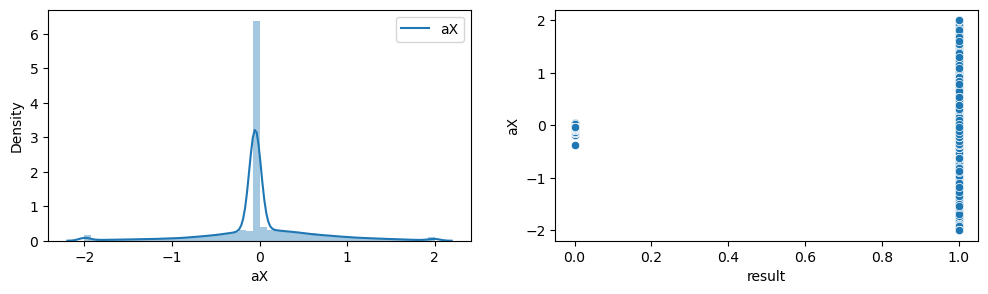

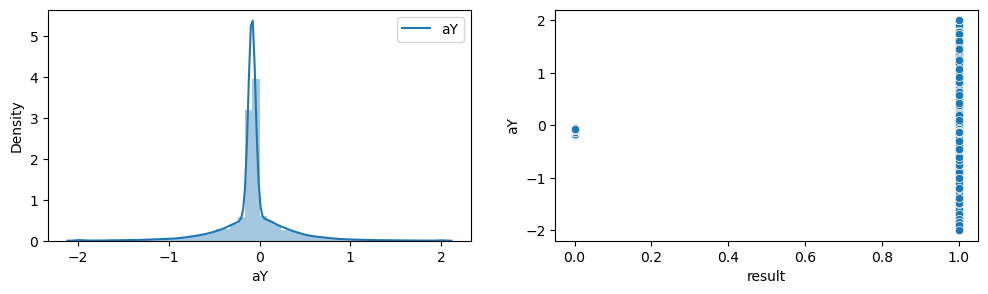

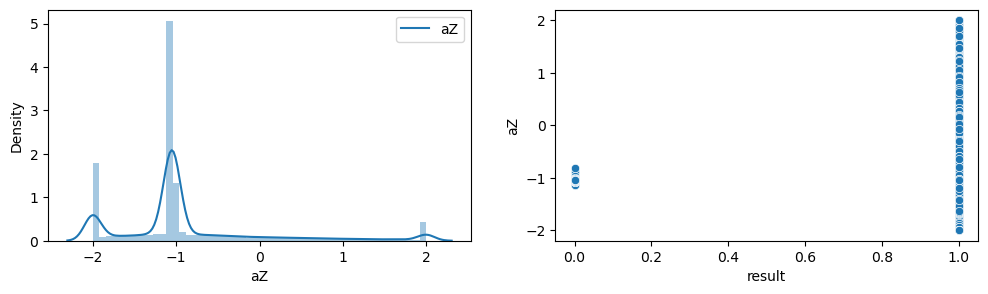

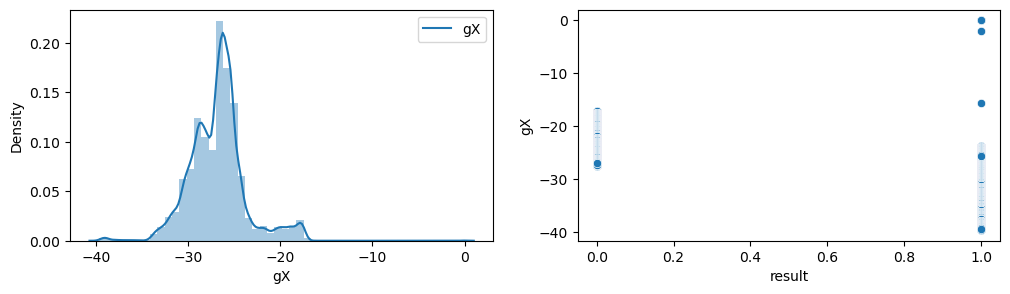

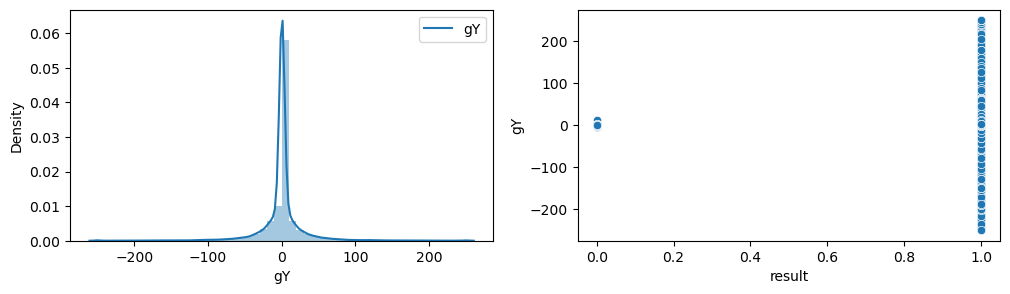

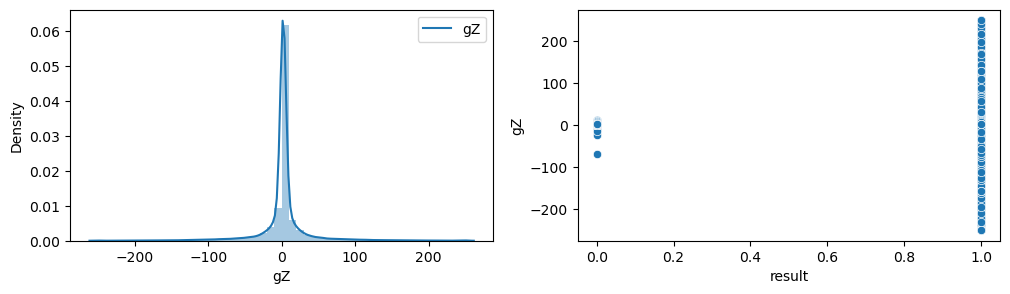

In [14]:
plot_eda('aX')
plot_eda('aY')
plot_eda('aZ')
plot_eda('gX')
plot_eda('gY')
plot_eda('gZ')

In [113]:
df0=df[df['result']==0] # df result = 0

In [114]:
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
aX,28678.0,-0.049634,0.015613,-0.37,-0.07,-0.04,-0.04,0.04
aY,28678.0,-0.083200,0.007028,-0.18,-0.09,-0.08,-0.08,-0.05
aZ,28678.0,-1.049731,0.006561,-1.14,-1.05,-1.05,-1.05,-0.81
gX,28678.0,-24.833134,2.442941,-27.60,-26.38,-25.65,-24.55,-17.10
gY,28678.0,0.471666,0.132697,-4.02,0.41,0.47,0.53,13.48
gZ,28678.0,2.049910,0.514245,-69.53,1.96,2.05,2.15,12.40
result,28678.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00


terlihat kondisi diam tidak semua fitur bernilai mendekati 0

## - DATA PREPROCESSING 2

In [15]:
# split: data modeling | data simulasi
df_modeling, df_simulasi = train_test_split(df, test_size=0.01, random_state=42)

In [16]:
df_modeling = df_modeling.reset_index(drop=True)
df_simulasi = df_simulasi.reset_index(drop=True)

In [17]:
df_modeling.shape, df_simulasi.shape

((58683, 7), (593, 7))

In [18]:
df_modeling['result'].value_counts(normalize=True)*100

1    51.631648
0    48.368352
Name: result, dtype: float64

In [19]:
df_simulasi['result'].value_counts(normalize=True)*100

1    50.421585
0    49.578415
Name: result, dtype: float64

In [27]:
# # save data
# df_modeling.to_csv('dataset/data_modeling_gempa.csv')
# df_simulasi.to_csv('dataset/data_simulasi_gempa.csv')

In [28]:
 # read dataset modeling
df_modeling = pd.read_csv('dataset/data_modeling_gempa.csv')

In [29]:
df_modeling.columns

Index(['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ', 'result'], dtype='object')

In [30]:
# Membagi fitur/prediktor dan label
X = df_modeling[['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ']]
y = df_modeling[['result']]

# Split dataset menjadi train, val, dan test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# scaling/normalisasi data
'''
  fit hanya pada data train 
  agar tidak terjadi data leakage/kebocoran data
'''
scaler_X = MinMaxScaler().fit(X_train)
X_train = scaler_X.transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((42251, 6), (42251, 1), (11737, 6), (11737, 1), (4695, 6), (4695, 1))

In [31]:
import joblib

joblib.dump(scaler_X, 'scaler/scaler_X_klasifikasi_gempa.save') 

['scaler/scaler_X_klasifikasi_gempa.save']

In [32]:
X.head()

,aX,aY,aZ,gX,gY,gZ
0,-0.04,-0.09,-1.04,-25.28,0.56,1.93
1,-0.07,-0.08,-1.05,-25.16,0.47,2.13
2,-0.04,-0.09,-1.05,-26.63,0.45,1.88
3,-0.09,0.04,-0.44,-38.23,-5.46,0.95
4,-0.03,-0.09,-1.05,-26.75,0.49,2.21


In [33]:
y.head()

,result
0,0
1,0
2,0
3,1
4,0


In [34]:
# Mengubah bentuk X
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)  
print(X_val.shape)
print(X_test.shape)

y_train=y_train.values
y_val=y_val.values
y_test=y_test.values

(42251, 1, 6)
(11737, 1, 6)
(4695, 1, 6)


## - MODELING & RESULT

### Model

In [35]:
# Membuat model GRU
model_gempa = Sequential()
model_gempa.add(GRU(64, 
                    input_shape=(1,6),
                    return_sequences=True,
                    activation='tanh'))
model_gempa.add(GRU(32,
                    activation='tanh'))
model_gempa.add(Dense(2, activation='softmax'))
model_gempa.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 64)             13824     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 23,298
Trainable params: 23,298
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_gempa.compile(optimizer='adam', 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

history_gempa = model_gempa.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=100, batch_size=64)

Epoch 1/100
661/661 [==============================] - 15s 14ms/step - loss: 0.4429 - accuracy: 0.7992 - val_loss: 0.3588 - val_accuracy: 0.8842
Epoch 2/100
661/661 [==============================] - 9s 13ms/step - loss: 0.2806 - accuracy: 0.9018 - val_loss: 0.1863 - val_accuracy: 0.9558
Epoch 3/100
661/661 [==============================] - 9s 13ms/step - loss: 0.1379 - accuracy: 0.9629 - val_loss: 0.1060 - val_accuracy: 0.9718
Epoch 4/100
661/661 [==============================] - 8s 12ms/step - loss: 0.0934 - accuracy: 0.9739 - val_loss: 0.0786 - val_accuracy: 0.9820
Epoch 5/100
661/661 [==============================] - 8s 13ms/step - loss: 0.0728 - accuracy: 0.9794 - val_loss: 0.0673 - val_accuracy: 0.9774
Epoch 6/100
661/661 [==============================] - 8s 13ms/step - loss: 0.0589 - accuracy: 0.9837 - val_loss: 0.0546 - val_accuracy: 0.9864
Epoch 7/100
661/661 [==============================] - 8s 13ms/step - loss: 0.0510 - accuracy: 0.9861 - val_loss: 0.0475 - val_accuracy

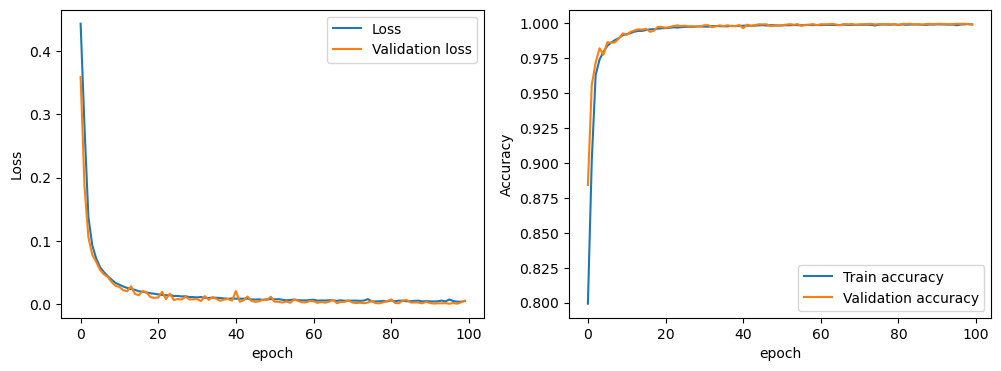

In [37]:
# plot loss & accuracy
plt.figure(figsize=(12, 4))
    
plt.subplot(121) # row , col , index 
plt.plot(history_gempa.history['loss'])
plt.plot(history_gempa.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Validation loss'], loc='upper right')

plt.subplot(122) 
plt.plot(history_gempa.history['accuracy'])
plt.plot(history_gempa.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Validation accuracy'], loc='lower right')
    
plt.show()

In [38]:
# Evaluasi model
train_scores = model_gempa.evaluate(X_train, y_train, verbose=0)
val_scores = model_gempa.evaluate(X_val, y_val, verbose=0)
test_scores = model_gempa.evaluate(X_test, y_test, verbose=0)

# dataframe untuk evaluasi model
df_eval = pd.DataFrame(index=['train', 'val', 'test'],
                       columns=['loss', 'accuracy'])

df_eval.loc['train', 'loss']=train_scores[0]
df_eval.loc['train', 'accuracy']=train_scores[1]

df_eval.loc['val', 'loss']=val_scores[0]
df_eval.loc['val', 'accuracy']=val_scores[1]

df_eval.loc['test', 'loss']=test_scores[0]
df_eval.loc['test', 'accuracy']=test_scores[1]

df_eval

,loss,accuracy
train,0.00687,0.998533
val,0.005988,0.999063
test,0.006312,0.998722


In [39]:
# save model dalam format .h5
model_gempa.save('model/model_klasifikasi_gempa.h5')

### Result

#### satu data

In [46]:
# prediksi 1 data
i=2
sample_test_X=X_test[i] # ambil X
sample_test_X=sample_test_X.reshape(sample_test_X.shape[0],1,6) # reshape X

sample_test_y=y_test[i] # ambil y

# predict
pred = model_gempa.predict(sample_test_X)
pred = np.argmax(pred)
print('status pred  :',pred)
print('status y test:',sample_test_y)

1/1 [==============================] - 1s 676ms/step
status pred  : 0
status y test: [0]


In [47]:
# df X
df_sample_test_X = pd.DataFrame(sample_test_X.reshape(1,6), columns = ['aX_scaled', 'aY_scaled', 'aZ_scaled', 
                                                                       'gX_scaled', 'gY_scaled', 'gMZ_scaled'])
# df X inverse
df_sample_test_X_inverse = scaler_X.inverse_transform(df_sample_test_X)
df_sample_test_X_inverse = pd.DataFrame(df_sample_test_X_inverse,columns = ['aX', 'aY', 'aZ', 'gX', 'gY', 'gMZ'])

# df y
df_sample_test_y=pd.DataFrame(sample_test_y, columns = ['status'])

# df pred
df_pred = pd.DataFrame(np.array([pred]), columns = ['status_pred'])

df_sample_test_X=df_sample_test_X.join([df_sample_test_X_inverse,df_sample_test_y,df_pred])
df_sample_test_X

,aX_scaled,aY_scaled,aZ_scaled,gX_scaled,gY_scaled,gMZ_scaled,aX,aY,aZ,gX,gY,gMZ,status,status_pred
0,0.4825,0.4825,0.24,0.366179,0.5008,0.50456,-0.07,-0.07,-1.04,-25.16,0.4,2.28,0,0


#### banyak data

In [48]:
# prediksi 1 data
a=0
b=6
sample_test_X=X_test[a:b] # ambil X
sample_test_X=sample_test_X.reshape(sample_test_X.shape[0],1,6) # reshape X

sample_test_y=y_test[a:b] # ambil y

# predict
pred = model_gempa.predict(sample_test_X)
pred = np.argmax(pred, axis=1)
print('status pred  :',pred)
print('status y test:',sample_test_y.reshape(-1))

1/1 [==============================] - 0s 53ms/step
status pred  : [0 1 0 1 0 1]
status y test: [0 1 0 1 0 1]


In [49]:
# df X
df_sample_test_X = pd.DataFrame(sample_test_X.reshape(sample_test_X.shape[0],6), 
                                columns = ['aX_scaled', 'aY_scaled', 'aZ_scaled', 
                                           'gX_scaled', 'gY_scaled', 'gMZ_scaled'])
# df X inverse
df_sample_test_X_inverse = scaler_X.inverse_transform(df_sample_test_X)
df_sample_test_X_inverse = pd.DataFrame(df_sample_test_X_inverse,
                                        columns = ['aX', 'aY', 'aZ', 'gX', 'gY', 'gMZ'])

# df y
df_sample_test_y=pd.DataFrame(sample_test_y, 
                              columns = ['status'])

# df pred
df_pred = pd.DataFrame(np.array([pred]).reshape(sample_test_X.shape[0],1), 
                       columns = ['status_pred'])

df_sample_test_X=df_sample_test_X.join([df_sample_test_X_inverse,df_sample_test_y,df_pred])
df_sample_test_X

,aX_scaled,aY_scaled,aZ_scaled,gX_scaled,gY_scaled,gMZ_scaled,aX,aY,aZ,gX,gY,gMZ,status,status_pred
0,0.4900,0.4775,0.2375,0.320060,0.50110,0.50418,-0.04,-0.09,-1.05,-26.99,0.55,2.09,0,0
1,0.3475,0.3150,0.8550,0.267641,0.58200,0.45520,-0.61,-0.74,1.42,-29.07,41.00,-22.40,1,1
2,0.4825,0.4825,0.2400,0.366179,0.50080,0.50456,-0.07,-0.07,-1.04,-25.16,0.40,2.28,0,0
3,0.4800,0.3750,0.0000,0.242944,0.49478,0.51164,-0.08,-0.50,-2.00,-30.05,-2.61,5.82,1,1
4,0.4900,0.4800,0.2375,0.366179,0.50084,0.50456,-0.04,-0.08,-1.05,-25.16,0.42,2.28,0,0
5,0.3825,0.5800,0.1525,0.252268,0.47856,0.50358,-0.47,0.32,-1.39,-29.68,-10.72,1.79,1,1


---

# 2. SIMULASI KLASIFIKASI GEMPA

In [1]:
# import libraries
import pandas as pd
import numpy as np
import joblib
from keras.models import load_model

In [2]:
# load scaler & model
scaler_X_gempa = joblib.load('scaler/scaler_X_klasifikasi_gempa.save')
model_klasifikasi_gempa = load_model('model/model_klasifikasi_gempa.h5')

df_simulasi=pd.read_csv('dataset/data_simulasi_gempa.csv')

In [52]:
df_simulasi.head()

,aX,aY,aZ,gX,gY,gZ,result
0,-0.09,1.23,-2.00,-29.19,-120.73,19.60,1
1,-0.04,-0.09,-1.05,-26.63,0.46,2.06,0
2,-0.67,-0.02,-2.00,-28.58,-30.82,8.13,1
3,-0.04,-0.09,-1.06,-26.99,0.51,2.05,0
4,-1.47,-0.65,-0.29,-26.26,28.15,-103.79,1


In [53]:
def klasifikasi_gempa(X, scaler_X, model):
    X=X.iloc[:,:6]
    X_scaled = scaler_X_gempa.transform(X)
    X_scaled=X_scaled.reshape(1,1,6)
    # predict
    y_pred = model_klasifikasi_gempa.predict(X_scaled, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    # df
    df_y_pred = pd.DataFrame(y_pred, columns=['status_pred'])
    df_klasifikasi = X_gempa.join(df_y_pred)
    return df_klasifikasi

def get_info_gempa(data):
    display(data)
    status_pred = data['status_pred'][0]
    if status_pred == 1:
        print("Status: Gempa")
    else:
        print("Status: Bukan Gempa")


## Gempa

In [54]:
X_gempa = df_simulasi.sample(1).reset_index(drop=True)

y_pred_gempa = klasifikasi_gempa(X=X_gempa, 
                                 scaler_X=scaler_X_gempa, 
                                 model=model_klasifikasi_gempa)
get_info_gempa(data=y_pred_gempa)

,aX,aY,aZ,gX,gY,gZ,result,status_pred
0,0.02,-0.63,-1.09,-28.46,4.7,8.31,1,1


Status: Gempa


## Bukan gempa

In [56]:
X_gempa = df_simulasi.sample(1).reset_index(drop=True)

y_pred_gempa = klasifikasi_gempa(X=X_gempa, 
                                 scaler_X=scaler_X_gempa, 
                                 model=model_klasifikasi_gempa)
get_info_gempa(data=y_pred_gempa)

,aX,aY,aZ,gX,gY,gZ,result,status_pred
0,-0.04,-0.09,-1.06,-26.99,0.37,2.22,0,0


Status: Bukan Gempa


## Evaluasi

In [26]:
df=df_simulasi.copy()

In [27]:
# Membagi fitur/prediktor dan label
X = df[['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ']]
y = df[['result']]

# scaling/normalisasi data
scaler_X = scaler_X_gempa
X = scaler_X.transform(X)

X.shape, y.shape

((593, 6), (593, 1))

In [28]:
y.value_counts()

result
1         299
0         294
dtype: int64

In [29]:
# Mengubah bentuk X
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
print(X.shape)
y=y.values

(593, 1, 6)


In [30]:
# Evaluasi model
simulasi_scores = model_klasifikasi_gempa.evaluate(X, y, verbose=0)

# dataframe untuk evaluasi model
df_eval = pd.DataFrame(index=['simulasi'],
                       columns=['loss', 'accuracy'])

df_eval.loc['simulasi', 'loss']=simulasi_scores[0]
df_eval.loc['simulasi', 'accuracy']=simulasi_scores[1]

df_eval

,loss,accuracy
simulasi,0.001765,1.0


---